# Amyloid & prion protein classification

Based upon code & knowledge outlined at https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

## Preprocess
### Parse FASTA into CSV
The PLAAC dataset is in FASTA format, which will be parsed into a CSV table for preprocessing. We'll record the gene name, Uniprot sequence range & sequence text, and add positive prion & amyloid classifications.

In [2]:
import sys, os

plaacFasta = 'positiveExamples/yeastPrion.fasta'
negativeFasta = 'negativeExamples/negative.fasta'
positiveDataset = 'positiveExamples/positiveDataset.csv'
negativeDataset = 'negativeExamples/negativeDataset.csv'
destination_folder = "./output"

def fastaToCSV(fastaPath, csvPath, prionClassification = 0, amyloidClassification = 0):
    # Read in FASTA
    with open(fastaPath, 'r') as file:
        lines = ["header,sequence,prion,amyloid"]
        lines_i = file.readlines()

        seq = ''
        index = 0
        while index < len(lines_i):
            if lines_i[index][0] == '>':
                'Fasta head line'
                # append sequence & prion classification
                if seq: lines.append(seq + ',' + str(prionClassification) + ',' + str(amyloidClassification))
                seq = ''
                # remove FASTA syntactic sugar
                seq_id = lines_i[index].strip().replace(',', '').replace('>', '')
                # remove uniprot metadata using pipe & equal sign delimiter
                seq_id = " ".join((seq_id.split(" "))[1:]) if "|" in seq_id else seq_id
                lastHeaderIndex = seq_id.index("=") - 3 if ('=' in seq_id) else len(seq_id)
                lines.append('\n' + seq_id[:lastHeaderIndex] + ',')
            else:
                'Sequence line'
                seq += lines_i[index].strip()
                if (index == len(lines_i) - 1): lines.append(seq + ',' + str(prionClassification) + ',' + str(amyloidClassification))
            index += 1
        lines.append("\n")
        file.close()

    # Output CSV file
    with open(csvPath, 'w') as file:
        file.writelines(lines)
        file.close()
    return

# negative
fastaToCSV(negativeFasta, negativeDataset)
# PLAAC prions
fastaToCSV(plaacFasta, positiveDataset, 1, 1)


### Parse JSON into CSV
The Amypro dataset is in JSON format, so we'll use JSON tools to parse data into a CSV table of the same format as above. 

In [3]:
import json 
import csv 

amyproDataset = 'positiveExamples/amyproAmyloids.json'

with open(amyproDataset, encoding = 'utf-8-sig') as json_file: 
    data = json.load(json_file) 
    lines = []
    for amyloid in data:
        lines.append(amyloid["protein_name"].replace(',', '') + (' [' + amyloid["uniprot_start"] + '-' + amyloid["uniprot_end"] + ']' if amyloid["uniprot_start"] != "" else "")+ ',')
        lines.append(amyloid["sequence"] + ',')
        lines.append(str(amyloid["prion_domain"]) + ',')
        # positive amyloid classification
        lines.append('1' + '\n')
    json_file.close()

# Append to CSV file
with open(positiveDataset, 'a') as file:
    file.writelines(lines)
    file.close()

### Read CSVs into a Panda dataframe to generate training, testing & validation datasets
For performance reasons, header names are replaced with indexes that reference an in-memory dictionary. A constant random seed may be assigned to ensure the same data is split across training, testing & validation.

In [4]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split, KFold

train_validation_ratio = 0.85
train_test_ratio = 0.7
df_train, df_test = pd.DataFrame(), pd.DataFrame()

def generateDataFrames(randomSeed):
    # Read raw data & combine 
    df_positive = pd.read_csv(positiveDataset).applymap(lambda x: x.strip() if type(x)==str else x)
    df_negative = pd.read_csv(negativeDataset).applymap(lambda x: x.strip() if type(x)==str else x)
    df_full = pd.concat([df_positive, df_negative], ignore_index=True)

    # Generate in-memory index for headers & compress dataframe
    datasetIndex = {}
    for index in range(len(df_full.index)):
        datasetIndex[index] = df_full.at[index, 'header']
        df_full.at[index, 'header'] = index

    # Split amyloid class
    df_notAmyloid = df_full[df_full['amyloid'] == 0]
    df_amyloid = df_full[df_full['amyloid'] == 1]

    # Train-validation split
    df_amyloid_trainSuperset, df_amyloid_validation = train_test_split(df_amyloid, train_size = train_validation_ratio, random_state = randomSeed)
    df_notAmyloid_trainSuperset, df_notAmyloid_validation  = train_test_split(df_notAmyloid, train_size = train_validation_ratio, random_state = randomSeed)

    # Train-test split
    df_amyloid_train, df_amyloid_test = train_test_split(df_amyloid_trainSuperset, train_size = train_test_ratio, random_state = randomSeed)
    df_notAmyloid_train, df_notAmyloid_test = train_test_split(df_notAmyloid_trainSuperset, train_size = train_test_ratio, random_state = randomSeed)

    # Concatenate splits of different labels into training, testing & validation sets
    df_train = pd.concat([df_amyloid_train, df_notAmyloid_train], ignore_index=True, sort=False)
    df_test = pd.concat([df_amyloid_test, df_notAmyloid_test], ignore_index=True, sort=False)
    df_valid = pd.concat([df_amyloid_validation, df_notAmyloid_validation], ignore_index=True, sort=False)
    df_full = pd.concat([df_train, df_test], ignore_index=True, sort=False)

    # Write preprocessed data
    df_train.to_csv('train.csv', index=False)
    df_test.to_csv('test.csv', index=False)
    df_valid.to_csv('valid.csv', index=False)
    df_full.to_csv('full.csv', index=False)

    return datasetIndex



## Implement the model
### Import necessary libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

# set processing device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# data 

from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torch.utils.data import ConcatDataset

# model

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# training

import torch.optim as optim
from tensorboardX import SummaryWriter
tensorboard_writer = SummaryWriter('./tensorboard_logs')

# evaluation

from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns


### Load data


In [6]:
# Tokenize peptide sequences by splitting into individual amino acids
def split(sequence):
    return [char for char in sequence] 

def declareFields(data_dir='./'):
    header = Field(sequential=False, dtype=torch.int, use_vocab=False, include_lengths=False)
    sequence = Field(tokenize=split, sequential=True, include_lengths=True, batch_first=True)
    amyloidLabel = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float, include_lengths=False)
    prionLabel = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float, include_lengths=False)

    fields = [('header', header), ('sequence', sequence), ('prion', prionLabel), ('amyloid', amyloidLabel)]
    # Create TabularDatasets for vocab & fold splits
    train, test = TabularDataset.splits(path=data_dir, train="train.csv", test="test.csv", format='CSV', fields=fields, skip_header=True)
    full = ConcatDataset([train, test])

    # Vocabulary
    sequence.build_vocab(train)
    print("Vocabulary: " + str(sequence.vocab.stoi.items()))

    return full, fields, sequence

randomSeed = int(abs(np.random.normal() * 10))
datasetIndex = generateDataFrames(randomSeed)
fullDataset, fields, sequence = declareFields()
  

Vocabulary: dict_items([('<unk>', 0), ('<pad>', 1), ('L', 2), ('S', 3), ('A', 4), ('E', 5), ('G', 6), ('T', 7), ('V', 8), ('K', 9), ('P', 10), ('D', 11), ('N', 12), ('Q', 13), ('R', 14), ('I', 15), ('F', 16), ('Y', 17), ('H', 18), ('M', 19), ('C', 20), ('W', 21), ('X', 22)])


In [7]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

### Model
A stacked, bidirectional gated recurrent unit (GRU) network will be applied to learn amyloidogenic & prionogenic relations in peptide sequences. 

This network is composed of an embedding layer to vectorize input sequences, two GRU layers, and a fully-connected linear output layer gated by sigmoidal activation.

Hyperparameters:
- embedding & hidden layer dimensions
- depth of LSTM 
- LSTM bidirectionality
- neuron dropout probability

In [8]:
class GRU(nn.Module):

    def __init__(self, vocab, dimension=128, sequenceDepth = 64, dropoutWithinLayers = 0.3, dropoutOutput = 0.3):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(len(vocab), sequenceDepth)
        self.dimension = dimension
        self.GRU = nn.GRU(input_size=sequenceDepth,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=dropoutWithinLayers)
        self.dropOutput = nn.Dropout(p=dropoutOutput)

        # output layer
        self.fc = nn.Linear(2 * dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.GRU(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.dropOutput(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

#### Second model
A similar, but less performant, long-short term memory model is supplied here.

In [9]:
class LSTM(nn.Module):

    def __init__(self, vocab, dimension=64):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(vocab), 32)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.5)
        self.dropOnOutput = nn.Dropout(p=0.5)

        # output layer
        self.fc = nn.Linear(2 * dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.dropOnOutput(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

## Train

### Training function



In [10]:
#### CSV row index sampler
def sampleCSV(csvFilePath, sampleType, sampler):
    df_full = pd.read_csv(csvFilePath)
    df_sample = df_full.iloc[sampler]
    df_sample.to_csv(destination_folder + '/sample' + sampleType + '.csv', index=False)
    return 'sample' + sampleType + '.csv'


In [10]:
def train(vocab,
          lr,
          dimension,
          sequenceDepth,
          dropoutWithinLayers,
          dropoutOutput,
          batchSize,
          criterion,
          dataset,
          fields,
          foldCount,
          config,
          file_path,
          num_epochs = 5,
          amyloid = True,
          best_valid_loss = float("inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = {i:[] for i in range(foldCount)}
    valid_loss_list = {i:[] for i in range(foldCount)}
    global_steps_list = {i:[] for i in range(foldCount)}

    # K-fold cross-validation loop

    kfold = KFold(n_splits=foldCount, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        # sample elements in list of IDs
        # train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        # test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        trainSamplePath = sampleCSV('full.csv', 'Train' + str(fold), train_ids)
        testSamplePath = sampleCSV('full.csv', 'Test' + str(fold), test_ids)

        # create datasets for current fold
         # Create TabularDatasets
        trainData, testData = TabularDataset.splits(path="./", train="output/sampleTrain" + str(fold) + ".csv", test="output/sampleTest" + str(fold) + ".csv", format='CSV', fields=fields, skip_header=True)

        # create iterators for current fold
            # sort by sequence length to keep batches consistent 
        train_iter =  BucketIterator(trainData, batch_size=batchSize, sort_key=lambda x: len(x.sequence),
                            device=device, sort=True, sort_within_batch=True)
        test_iter =  BucketIterator(testData, batch_size=batchSize, sort_key=lambda x: len(x.sequence),
                            device=device, sort=True, sort_within_batch=True)
        eval_every=len(train_iter) // 2

        # initialize model
        model = GRU(vocab=vocab, dimension=dimension, sequenceDepth=sequenceDepth, dropoutWithinLayers=dropoutWithinLayers, dropoutOutput=dropoutOutput).to(device)

        # load optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # training loop
        model.train()
        for epoch in range(num_epochs):
            for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in train_iter:           
                prionLabel = prionLabel.to(device)
                amyloidLabel = amyloidLabel.to(device)
                sequence = sequence.to(device)
                sequence_len = sequence_len.to(device)
                output = model(sequence, sequence_len.cpu())

                amyloidLoss = criterion(output, amyloidLabel)
                prionLoss = criterion(output, prionLabel)
                loss = amyloidLoss if amyloid else prionLoss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update running values
                running_loss += loss.item()
                global_step += 1
                
                # evaluation for this epoch
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():                    
                        # validation loop
                        for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in test_iter:   
                            prionLabel = prionLabel.to(device)
                            amyloidLabel = amyloidLabel.to(device)
                            sequence = sequence.to(device)
                            sequence_len = sequence_len.to(device)
                            output = model(sequence, sequence_len.cpu())
                            
                            amyloidLoss = criterion(output, amyloidLabel)
                            prionLoss = criterion(output, prionLabel)
                            loss = amyloidLoss if amyloid else prionLoss
                            valid_running_loss += loss.item()
                
                    # record loss
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(test_iter)
                    train_loss_list[fold].append(average_train_loss)
                    valid_loss_list[fold].append(average_valid_loss)
                    global_steps_list[fold].append(global_step)

                    # resetting running values
                    valid_running_loss = 0.0
                    running_loss = 0.0
                    model.train()
                    
                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                            .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter)*(foldCount),
                                    average_train_loss, average_valid_loss))
                    torch.save(model, destination_folder + f'/model{fold}.pt')
                    save_metrics(file_path + f'/metrics{fold}.pt', train_loss_list[fold], valid_loss_list[fold], global_steps_list[fold])


    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list

### Entry point for training amyloid-only model

Hyperparameters:
 - Learning rate
 - Epoch count
 - Loss function
 - Hidden layer size
 - Hidden layer depth

In [22]:
# hyperparameters
config = {'number_of_epochs': 5, 'batch_size': 8, 'dropout_within_layers': 0.3, 'dropout_output': 0.3, 'learning_rate': 0.00035, 'sequence_feature_depth':64, 'dimension':128}

training_losses, validation_losses, global_steps = train(
    vocab=sequence.vocab, lr=config['learning_rate'], criterion=nn.SmoothL1Loss(), fields=fields, dataset=fullDataset, foldCount=10, config=config, file_path = destination_folder, num_epochs=config['number_of_epochs'], dimension=config['dimension'], batchSize=config['batch_size'], sequenceDepth=config['sequence_feature_depth'], dropoutWithinLayers = config['dropout_within_layers'], dropoutOutput = config['dropout_output'])

FOLD 1
--------------------------------
Epoch [1/5], Step [17/1750], Train Loss: 0.1084, Valid Loss: 0.1619
Model saved to ==> ./output/metrics0.pt
Epoch [1/5], Step [34/1750], Train Loss: 0.1394, Valid Loss: 0.0826
Model saved to ==> ./output/metrics0.pt
Epoch [2/5], Step [51/1750], Train Loss: 0.1009, Valid Loss: 0.0643
Model saved to ==> ./output/metrics0.pt
Epoch [2/5], Step [68/1750], Train Loss: 0.0769, Valid Loss: 0.0468
Model saved to ==> ./output/metrics0.pt
Epoch [3/5], Step [85/1750], Train Loss: 0.0732, Valid Loss: 0.0420
Model saved to ==> ./output/metrics0.pt
Epoch [3/5], Step [102/1750], Train Loss: 0.0677, Valid Loss: 0.0313
Model saved to ==> ./output/metrics0.pt
Epoch [4/5], Step [119/1750], Train Loss: 0.0605, Valid Loss: 0.0358
Model saved to ==> ./output/metrics0.pt
Epoch [4/5], Step [136/1750], Train Loss: 0.0600, Valid Loss: 0.0292
Model saved to ==> ./output/metrics0.pt
Epoch [5/5], Step [153/1750], Train Loss: 0.0554, Valid Loss: 0.0374
Model saved to ==> ./out

## Evaluate
### Training losses

Model loaded from <== ./output/metrics0.pt
Model loaded from <== ./output/metrics1.pt
Model loaded from <== ./output/metrics2.pt
Model loaded from <== ./output/metrics3.pt
Model loaded from <== ./output/metrics4.pt
Model loaded from <== ./output/metrics5.pt
Model loaded from <== ./output/metrics6.pt
Model loaded from <== ./output/metrics7.pt
Model loaded from <== ./output/metrics8.pt
Model loaded from <== ./output/metrics9.pt


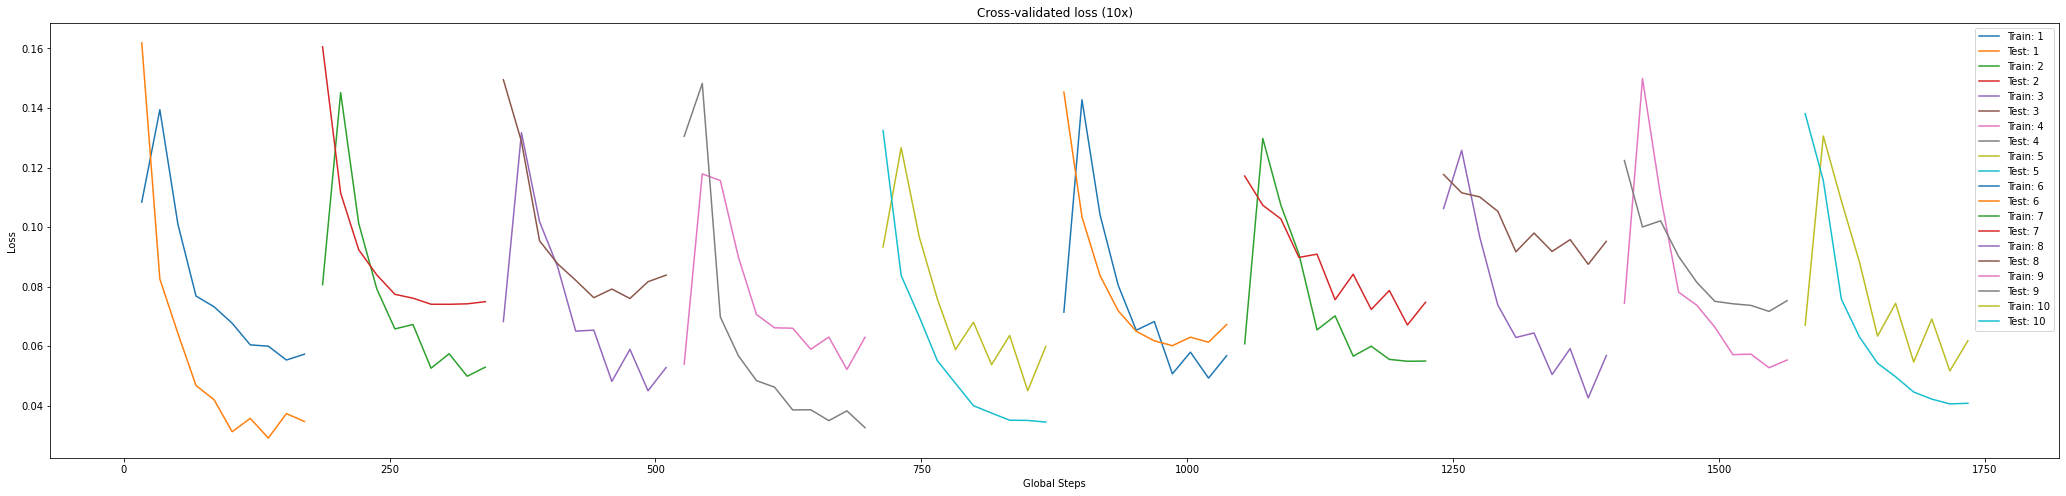

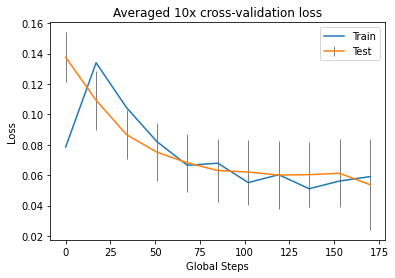

In [23]:
foldCount = 10

# average training losses 
totalTrainingLosses = pd.DataFrame(list(training_losses.values()))
totalTestingLosses = pd.DataFrame(list(validation_losses.values()))
globalSteps = pd.DataFrame(list(global_steps.values()))
totalTrainingLosses.to_csv(destination_folder + '/averageTrainingLosses.csv')
totalTestingLosses.to_csv(destination_folder + '/averageTestingLosses.csv')
globalSteps.to_csv(destination_folder + '/globalSteps.csv', index = False)


# load saved training losses
def loadSavedCSVList(csvPath):
    savedData = pd.read_csv(destination_folder + csvPath).values.T.tolist()
    savedData.pop(0)
    return pd.DataFrame(np.array(savedData).T.tolist())

# totalTrainingLosses = loadSavedCSVList('/averageTrainingLosses.csv')
# totalTestingLosses = loadSavedCSVList('/averageTestingLosses.csv')
# global_steps = pd.read_csv(destination_folder + '/globalSteps.csv').values.T.tolist()
# global_steps.pop(0)
# global_steps = np.array(global_steps).T.tolist()

if len(global_steps[0]) < len(global_steps[-1 + 4]): 
    global_steps[0].insert(0, 0)

averageTrainingLosses = totalTrainingLosses.mean(axis=0)
averageTrainingDeviation = totalTrainingLosses.std(axis=0)
averageTestingLosses= totalTestingLosses.mean(axis=0)
averageTestingDeviation = totalTestingLosses.std(axis=0)

# plot loss across folds
plt.figure(figsize=(36,8))
plt.title('Cross-validated loss (10x)')
for fold in range(foldCount):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + f'/metrics{fold}.pt')
    plt.plot(global_steps_list, train_loss_list, label=f'Train: {fold+1}')
    plt.plot(global_steps_list, valid_loss_list, label=f'Test: {fold+1}')
    plt.legend()
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.show()

# plot average loss across folds
plt.title('Averaged 10x cross-validation loss')
plt.plot(global_steps[0], averageTrainingLosses, label='Train')
plt.errorbar(global_steps[0], averageTestingLosses, averageTestingDeviation, label='Test', ecolor='black', elinewidth=0.5)
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Confusion matrix, heuristics & external validation

In [15]:
def runModel(model, foldCount = 0, csvDatasetPath = None, csvFoldPathBase = None, threshold=.5):
    y_pred = []
    y_true = []

    def evaluate(dataPath, y_pred, y_true):
        testData = TabularDataset(path=dataPath, format="CSV", fields=fields, skip_header=True)
        test_iter =  BucketIterator(testData, batch_size=16, sort_key=lambda x: len(x.sequence),
                                device=device, sort=True, sort_within_batch=True)
        with torch.no_grad():
            for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in test_iter:           
                prionLabel = prionLabel.to(device)
                amyloidLabel = amyloidLabel.to(device)
                sequence = sequence.to(device)
                sequence_len = sequence_len.to(device)
                output = model(sequence, sequence_len.cpu())

                output = (output > threshold).int()
                y_pred.extend(output.tolist())
                y_true.extend(amyloidLabel.tolist())

    model.eval()
    if not csvDatasetPath:
        for fold in range(foldCount):
            evaluate(destination_folder + "/sampleTest" + str(fold) + ".csv", y_pred, y_true)
    else:
        evaluate(csvDatasetPath, y_pred, y_true)
    
    return y_pred, y_true

### Classification report, confusion matrix & ROC

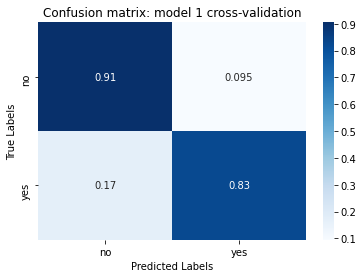

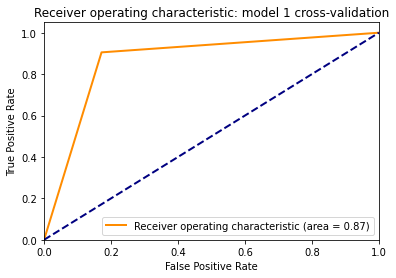

Classification Report
              precision    recall  f1-score   support

           1     0.8105    0.9051    0.8552       137
           0     0.9150    0.8284    0.8696       169

    accuracy                         0.8627       306
   macro avg     0.8627    0.8668    0.8624       306
weighted avg     0.8682    0.8627    0.8631       306

Matthews correlation: 0.7294900000504652


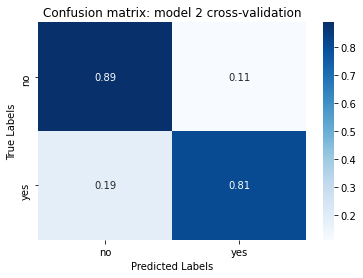

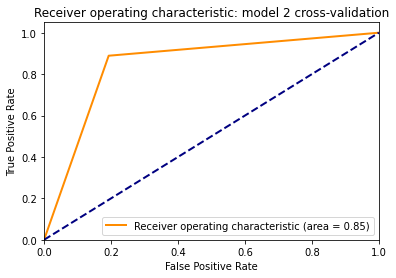

Classification Report 2:
              precision    recall  f1-score   support

           1     0.7843    0.8889    0.8333       135
           0     0.9020    0.8070    0.8519       171

    accuracy                         0.8431       306
   macro avg     0.8431    0.8480    0.8426       306
weighted avg     0.8501    0.8431    0.8437       306

Matthews correlation: 0.6910736907189411


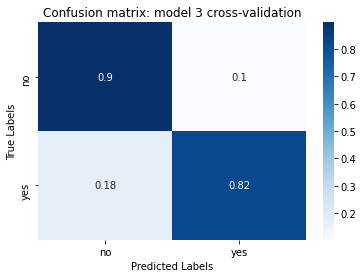

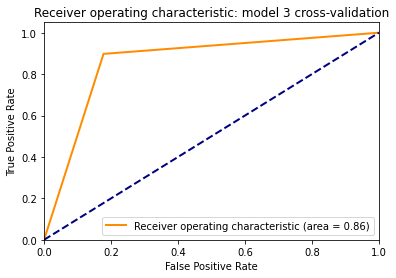

Classification Report 3:
              precision    recall  f1-score   support

           1     0.8039    0.8978    0.8483       137
           0     0.9085    0.8225    0.8634       169

    accuracy                         0.8562       306
   macro avg     0.8562    0.8601    0.8558       306
weighted avg     0.8617    0.8562    0.8566       306

Matthews correlation: 0.7163460360855919


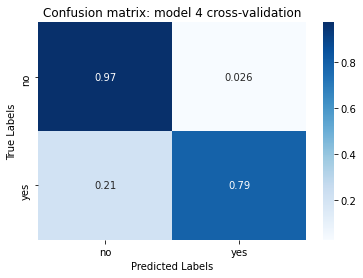

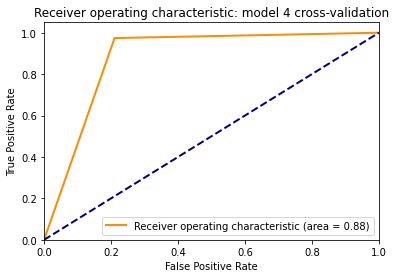

Classification Report 4:
              precision    recall  f1-score   support

           1     0.7386    0.9741    0.8401       116
           0     0.9804    0.7895    0.8746       190

    accuracy                         0.8595       306
   macro avg     0.8595    0.8818    0.8574       306
weighted avg     0.8887    0.8595    0.8616       306

Matthews correlation: 0.7409465668197894


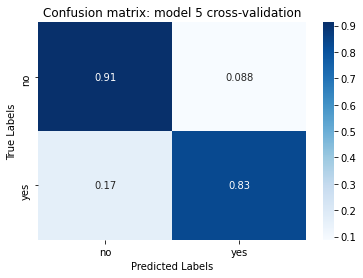

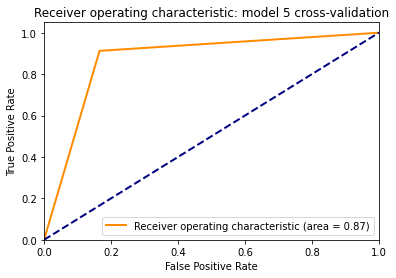

Classification Report 5:
              precision    recall  f1-score   support

           1     0.8170    0.9124    0.8621       137
           0     0.9216    0.8343    0.8758       169

    accuracy                         0.8693       306
   macro avg     0.8693    0.8734    0.8689       306
weighted avg     0.8747    0.8693    0.8696       306

Matthews correlation: 0.7426339640153383


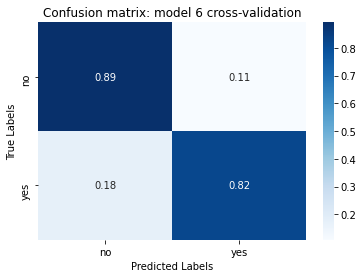

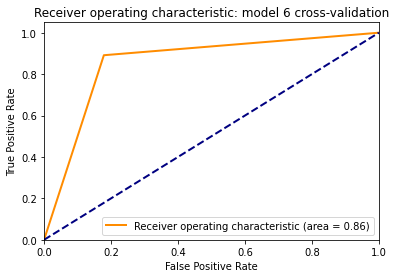

Classification Report 6:
              precision    recall  f1-score   support

           1     0.8039    0.8913    0.8454       138
           0     0.9020    0.8214    0.8598       168

    accuracy                         0.8529       306
   macro avg     0.8529    0.8564    0.8526       306
weighted avg     0.8577    0.8529    0.8533       306

Matthews correlation: 0.7092993656151906


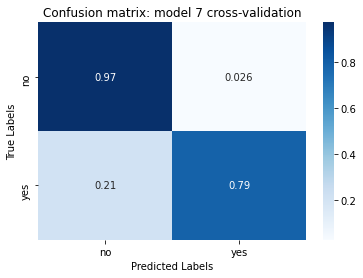

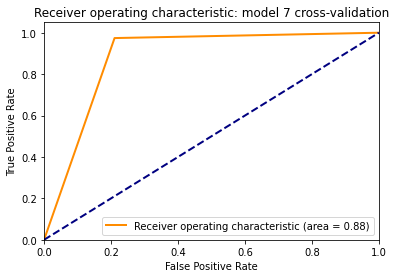

Classification Report 7:
              precision    recall  f1-score   support

           1     0.7386    0.9741    0.8401       116
           0     0.9804    0.7895    0.8746       190

    accuracy                         0.8595       306
   macro avg     0.8595    0.8818    0.8574       306
weighted avg     0.8887    0.8595    0.8616       306

Matthews correlation: 0.7409465668197894


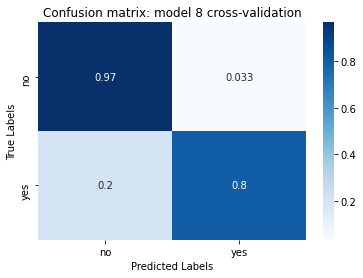

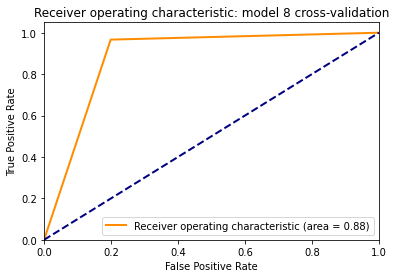

Classification Report 8:
              precision    recall  f1-score   support

           1     0.7582    0.9667    0.8498       120
           0     0.9739    0.8011    0.8791       186

    accuracy                         0.8660       306
   macro avg     0.8660    0.8839    0.8644       306
weighted avg     0.8893    0.8660    0.8676       306

Matthews correlation: 0.7496713736423323


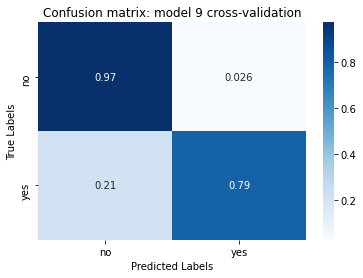

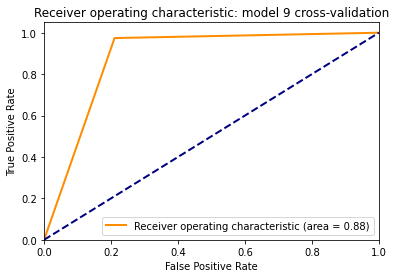

Classification Report 9:
              precision    recall  f1-score   support

           1     0.7386    0.9741    0.8401       116
           0     0.9804    0.7895    0.8746       190

    accuracy                         0.8595       306
   macro avg     0.8595    0.8818    0.8574       306
weighted avg     0.8887    0.8595    0.8616       306

Matthews correlation: 0.7409465668197894


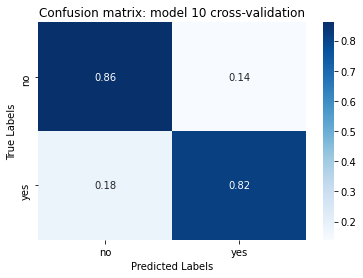

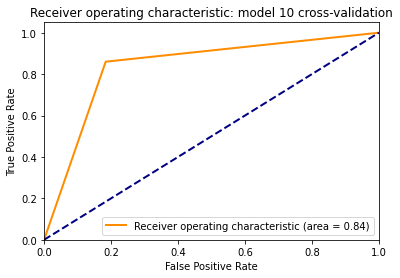

Classification Report 10:
              precision    recall  f1-score   support

           1     0.8039    0.8601    0.8311       143
           0     0.8693    0.8160    0.8418       163

    accuracy                         0.8366       306
   macro avg     0.8366    0.8380    0.8364       306
weighted avg     0.8387    0.8366    0.8368       306

Matthews correlation: 0.6746451518486976
bestROC: 0.8838709677419354, fold 8


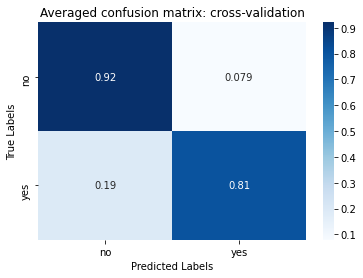

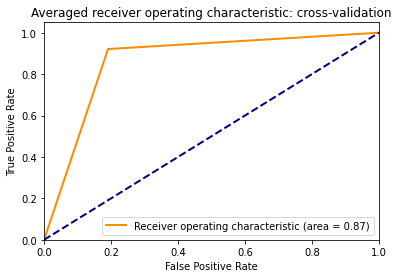

Classification Report
              precision    recall  f1-score   support

           1     0.7797    0.9212    0.8446      1295
           0     0.9333    0.8091    0.8668      1765

    accuracy                         0.8565      3060
   macro avg     0.8565    0.8652    0.8557      3060
weighted avg     0.8683    0.8565    0.8574      3060

Matthews correlation: 0.7216348716691929


In [16]:

def getHeuristics(y_true, y_pred, confusionMatrixTitle, ROCtitle, fold=None):
    cm = confusion_matrix(y_true, y_pred, labels=[1,0], normalize='true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues')

    ax.set_title(confusionMatrixTitle)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['no', 'yes'])
    ax.yaxis.set_ticklabels(['no', 'yes'])


    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label=f'Receiver operating characteristic (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROCtitle)
    plt.legend(loc="lower right")
    plt.show()

    print(f'Classification Report {fold + 1}:' if fold else 'Classification Report')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    print(f"Matthews correlation: " + str(matthews_corrcoef(y_true, y_pred)))
    return roc_auc

y_pred, y_true = dict(), dict()
y_pred_total, y_true_total = list(), list()
bestModel = { 'model': None, 'fold': 0}
bestROC = 0
for fold in range(foldCount):
    model = torch.load(destination_folder + f'/model{fold}.pt')
    y_pred[fold], y_true[fold] = runModel(model, foldCount, csvFoldPathBase="./output/sampleTest")
    y_pred_total += y_pred[fold]
    y_true_total += y_true[fold]
    roc = getHeuristics(y_pred[fold], y_true[fold], f"Confusion matrix: model {fold + 1} cross-validation", f"Receiver operating characteristic: model {fold + 1} cross-validation", fold)
    if roc > bestROC: 
        bestROC = roc
        bestModel['model'], bestModel['fold'] = model, fold + 1
print("bestROC: " + str(bestROC) + ', fold ' + str(bestModel['fold']))

totalExternalRoc = getHeuristics(y_pred_total, y_true_total, f"Averaged confusion matrix: cross-validation", f"Averaged receiver operating characteristic: cross-validation", None)


#### External validation

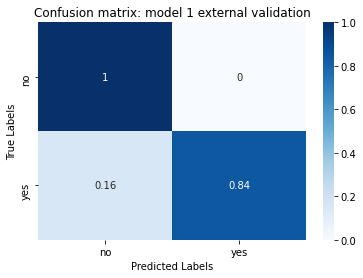

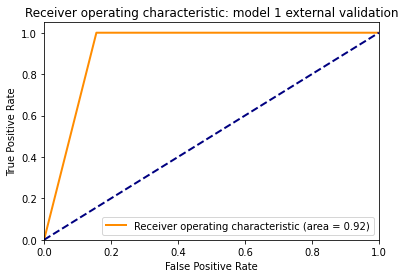

Classification Report
              precision    recall  f1-score   support

           1     0.8148    1.0000    0.8980        22
           0     1.0000    0.8438    0.9153        32

    accuracy                         0.9074        54
   macro avg     0.9074    0.9219    0.9066        54
weighted avg     0.9246    0.9074    0.9082        54

Matthews correlation: 0.82915619758885


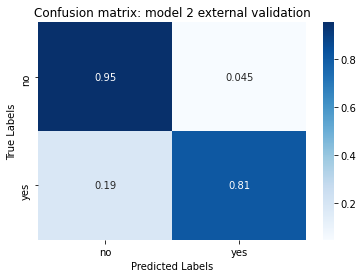

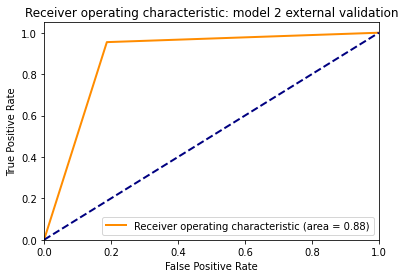

Classification Report 2:
              precision    recall  f1-score   support

           1     0.7778    0.9545    0.8571        22
           0     0.9630    0.8125    0.8814        32

    accuracy                         0.8704        54
   macro avg     0.8704    0.8835    0.8692        54
weighted avg     0.8875    0.8704    0.8715        54

Matthews correlation: 0.753778361444409


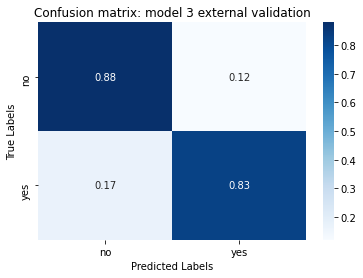

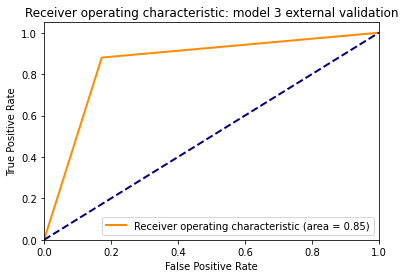

Classification Report 3:
              precision    recall  f1-score   support

           1     0.8148    0.8800    0.8462        25
           0     0.8889    0.8276    0.8571        29

    accuracy                         0.8519        54
   macro avg     0.8519    0.8538    0.8516        54
weighted avg     0.8546    0.8519    0.8521        54

Matthews correlation: 0.705642285072797


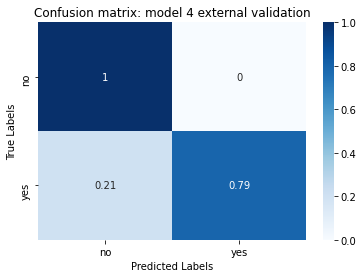

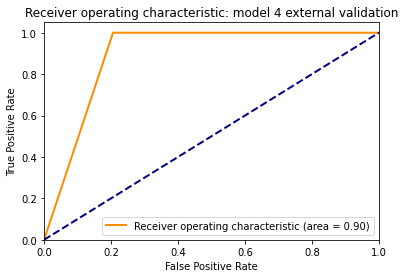

Classification Report 4:
              precision    recall  f1-score   support

           1     0.7407    1.0000    0.8511        20
           0     1.0000    0.7941    0.8852        34

    accuracy                         0.8704        54
   macro avg     0.8704    0.8971    0.8682        54
weighted avg     0.9040    0.8704    0.8726        54

Matthews correlation: 0.7669649888473704


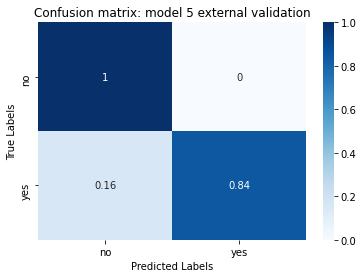

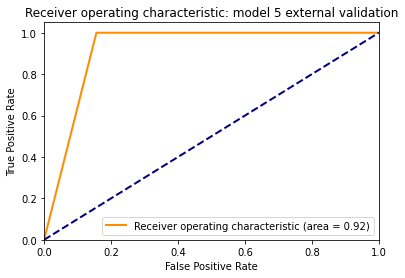

Classification Report 5:
              precision    recall  f1-score   support

           1     0.8148    1.0000    0.8980        22
           0     1.0000    0.8438    0.9153        32

    accuracy                         0.9074        54
   macro avg     0.9074    0.9219    0.9066        54
weighted avg     0.9246    0.9074    0.9082        54

Matthews correlation: 0.82915619758885


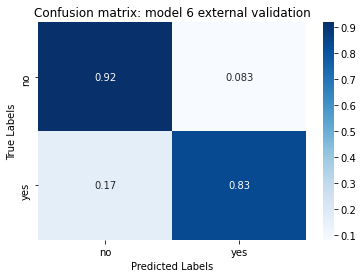

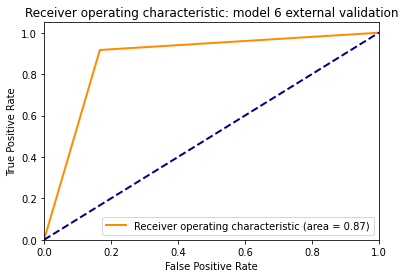

Classification Report 6:
              precision    recall  f1-score   support

           1     0.8148    0.9167    0.8627        24
           0     0.9259    0.8333    0.8772        30

    accuracy                         0.8704        54
   macro avg     0.8704    0.8750    0.8700        54
weighted avg     0.8765    0.8704    0.8708        54

Matthews correlation: 0.7453559924999299


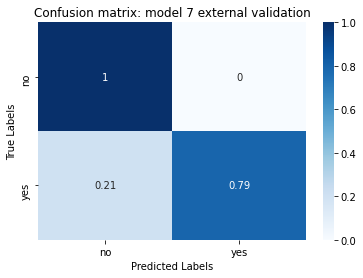

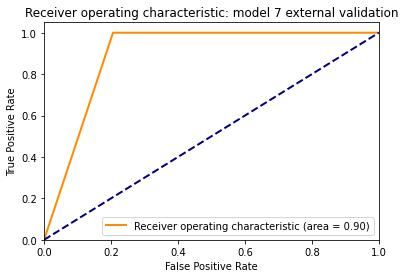

Classification Report 7:
              precision    recall  f1-score   support

           1     0.7407    1.0000    0.8511        20
           0     1.0000    0.7941    0.8852        34

    accuracy                         0.8704        54
   macro avg     0.8704    0.8971    0.8682        54
weighted avg     0.9040    0.8704    0.8726        54

Matthews correlation: 0.7669649888473704


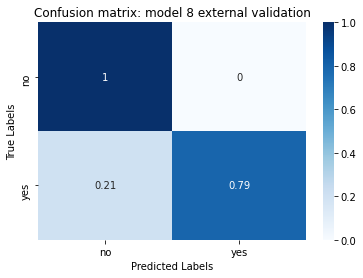

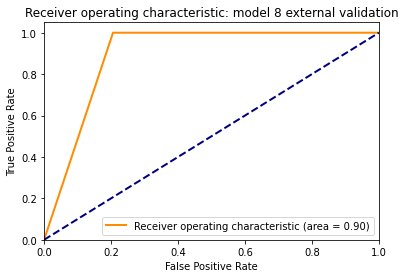

Classification Report 8:
              precision    recall  f1-score   support

           1     0.7407    1.0000    0.8511        20
           0     1.0000    0.7941    0.8852        34

    accuracy                         0.8704        54
   macro avg     0.8704    0.8971    0.8682        54
weighted avg     0.9040    0.8704    0.8726        54

Matthews correlation: 0.7669649888473704


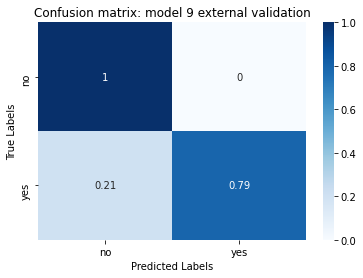

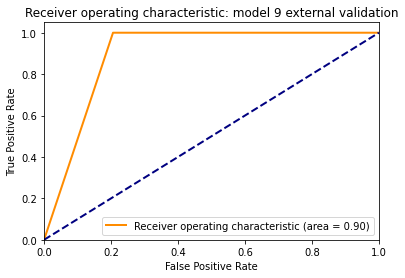

Classification Report 9:
              precision    recall  f1-score   support

           1     0.7407    1.0000    0.8511        20
           0     1.0000    0.7941    0.8852        34

    accuracy                         0.8704        54
   macro avg     0.8704    0.8971    0.8682        54
weighted avg     0.9040    0.8704    0.8726        54

Matthews correlation: 0.7669649888473704


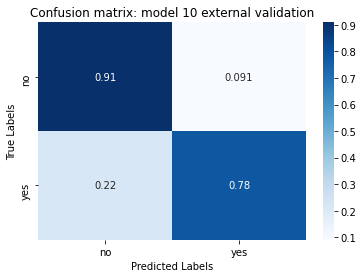

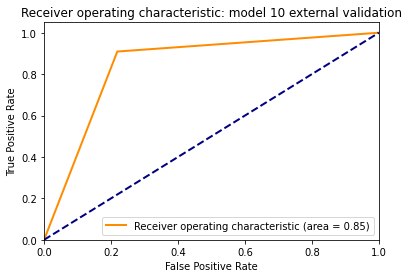

Classification Report 10:
              precision    recall  f1-score   support

           1     0.7407    0.9091    0.8163        22
           0     0.9259    0.7812    0.8475        32

    accuracy                         0.8333        54
   macro avg     0.8333    0.8452    0.8319        54
weighted avg     0.8505    0.8333    0.8348        54

Matthews correlation: 0.6784005252999682
bestROC: 0.921875, model 1
best external model = best cross-validated model? False


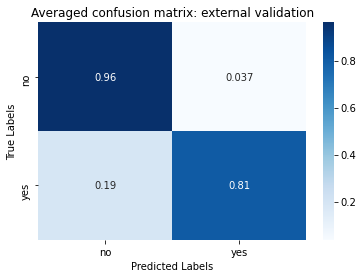

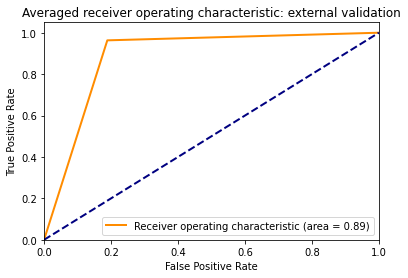

Classification Report
              precision    recall  f1-score   support

           1     0.7741    0.9631    0.8583       217
           0     0.9704    0.8111    0.8836       323

    accuracy                         0.8722       540
   macro avg     0.8722    0.8871    0.8710       540
weighted avg     0.8915    0.8722    0.8735       540

Matthews correlation: 0.7592152611088847


In [17]:

validationDataPath = './valid.csv'
foldCount=10
y_pred_external, y_true_external = dict(), dict()
y_pred_total, y_true_total = list(), list()

bestExternalModel = { 'model': None, 'fold': 0}
bestExternalROC = 0
for fold in range(foldCount):
    model = torch.load(destination_folder + f'/model{fold}.pt')
    y_pred_external[fold], y_true_external[fold] = runModel(model, foldCount, csvDatasetPath=validationDataPath)
    y_pred_total += y_pred_external[fold]
    y_true_total += y_true_external[fold]
    roc = getHeuristics(y_pred_external[fold], y_true_external[fold], f"Confusion matrix: model {fold + 1} external validation", f"Receiver operating characteristic: model {fold + 1} external validation", fold)
    if roc > bestExternalROC: 
        bestExternalROC = roc
        bestExternalModel['model'], bestExternalModel['fold'] = model, fold + 1
print("bestROC: " + str(bestExternalROC) + ', model ' + str(bestExternalModel['fold']))
print("best external model = best cross-validated model? " + ("True" if bestModel['fold'] == bestExternalModel['fold'] else "False"))

totalExternalRoc = getHeuristics(y_pred_total, y_true_total, f"Averaged confusion matrix: external validation", f"Averaged receiver operating characteristic: external validation", None)



## Apply
Use the model to search for amyloidogenic sequences in the Gut Phage Database, and analyze results.

In [63]:
def compressHeaders(FASTApath, CSVpath):
    print("Converting to CSV...")
    fastaToCSV(FASTApath, CSVpath)

    print("Reading CSV as dataframe...")
    df_realData = pd.read_csv(CSVpath, engine='python')

    # Generate in-memory index for headers & compress dataframe
    realDatasetIndex = {}
    print("Generating header index...")
    for index in range(len(df_realData.index)):
        realDatasetIndex[index] = df_realData.at[index, 'header']
        df_realData.at[index, 'header'] = index
    print("Writing compressed CSV...")
    df_realData.to_csv(CSVpath, index=False)
    
    return realDatasetIndex


## Gut phage database


In [64]:
#### Parse FASTA into CSV

gpdDatasetPath = './GPD_proteome.faa'
gpdCSVDatasetPath = './GPD_proteome.csv'

gpdDatasetIndex = compressHeaders(gpdDatasetPath, gpdCSVDatasetPath)
print("done!")

Converting to CSV...
Reading CSV as dataframe...
Generating header index...
Writing compressed CSV...
done!


In [25]:
#### Chunk CSV into bins
gpdChunkFolder = "./outputChunks"

print("Reading data...")
df_gpd = pd.read_csv(gpdCSVDatasetPath)

print("Chunking...")
n = 760000
chunks = [df_gpd[i:i+n] for i in range(0,df_gpd.shape[0],n)]

for i in range(0,df_gpd.shape[0],n):
    df_gpd[i:i+n].to_csv(gpdChunkFolder + f"/gpd{int(i/n)}.csv", index=False)
    print(f"Saved chunk {int(i/n)}.")

print("done!")

Reading data...


NameError: name 'gpdCSVDatasetPath' is not defined

### Get predictions

In [72]:

best_model = torch.load('./bestModel' + f'/model4.pt')
gpd_predictions = list()

gpd_predictions, null = runModel(best_model, foldCount=10, csvFoldPathBase='./outputChunks/gpd')
    
print("done!")

building iterator 0...
evaluating 0...
building iterator 1...
evaluating 1...
building iterator 2...
evaluating 2...
building iterator 3...
evaluating 3...
building iterator 4...
evaluating 4...
building iterator 5...
evaluating 5...
building iterator 6...
evaluating 6...
building iterator 7...
evaluating 7...
building iterator 8...
evaluating 8...
building iterator 9...
evaluating 9...
done!


In [73]:
### Write positives
from Bio.SeqIO import FastaIO
from Bio import SeqIO
output_file = "./output/gpdPositivesAlt.fasta"
fasta_out = FastaIO.FastaWriter(output_file, wrap=None)

print("generating sequence-header index...")

gpdProteinDict = SeqIO.index(gpdDatasetPath, "fasta")

print("finding positives...")
positiveCount = 0
for index, prediction in enumerate(gpd_predictions):
    if prediction == 1:
        fasta_out.write_record(gpdProteinDict[gpdDatasetIndex[index]])
        positiveCount += 1

print(f"found {positiveCount} positives")
print("done!")

generating sequence-header index...
finding positives...
found 310485 positives
done!


### Analyze predictions

In [74]:
#### Load GPD annotations to find results with functional annotations
print("Reading annotations...")
df_gpdAnnotations = pd.read_csv("./GPD_proteome_orthology_assignment.txt", sep="\t", dtype=str, na_filter=False)

# Generate in-memory index for protein annotations
positiveAnnotationsIndex = {}
print("Generating protein label index...")
for index in range(len(df_gpdAnnotations.index)):
    positiveAnnotation[df_gpdAnnotations.at[index, 'query_name']] = index
print("done!")
df_gpdAnnotations.head()

Generating protein label index...
done!


,query_name,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,best_tax_level,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,tax_scope,eggNOG OGs,COG Functional Category,eggNOG free text description,Unnamed: 21
0,uvig_48111_1,1408422.JHYF01000013_gene535,1.8e-37,163.7,Clostridiaceae,,,4.1.99.22,"ko:K03639,ko:K06871","ko00790,ko01100,ko04122,map00790,map01100,map0...",...,RC03420,"ko00000,ko00001,ko01000",,,,Bacteria,"1TQPS@1239,24A6D@186801,36G9K@31979,COG0641@1,...",C,4Fe-4S single cluster domain,
1,uvig_48111_2,NA,,,,,,,,,...,,,,,,,,,,
2,uvig_48111_5,NA,,,,,,,,,...,,,,,,,,,,
3,uvig_87711_3,NA,,,,,,,,,...,,,,,,,,,,
4,uvig_48111_6,1111454.HMPREF1250_0782,5.8e-19,100.5,Negativicutes,,,3.4.21.88,ko:K01356,,...,,"ko00000,ko00002,ko01000,ko01002,ko03400",,,,Bacteria,"1VGT2@1239,4H5RI@909932,COG1974@1,COG1974@2",K,Helix-turn-helix XRE-family like proteins,


In [79]:
#### Big n-gram analysis of positive peptides in GPD annotations
from Bio import SeqIO

print("generating sequence-header index...")

gpdResultsPath = './output/gpdPositives.fasta'
gpdPositivesDict = SeqIO.index(gpdResultsPath, "fasta")

collectiveProteinDescriptions = ''
print("building big n-gram...")

foundCount = 0
for header in gpdPositivesDict:
    annotation = df_gpdAnnotations.at[positiveLabelIndex[header], 'eggNOG free text description']
    if annotation != "":
        foundCount += 1
        collectiveProteinDescriptions += annotation + ','

print("writing to csv...")
text_file = open("./output/positiveNgramAnnotations.txt", "w")
n = text_file.write(collectiveProteinDescriptions)
text_file.close()

print(f"matched {foundCount} annotations")
print("done!")


generating sequence-header index...
building big n-gram...
writing to csv...
matched 106373 annotations
done!


In [112]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.collocations import TrigramCollocationFinder, BigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures, BigramAssocMeasures

from nltk.corpus import stopwords
  
stopset = set(stopwords.words('english'))
stop_words = set(stopwords.words('english')) 
trigramStats = TrigramAssocMeasures()

annotationTokens = word_tokenize(collectiveProteinDescriptions) 
stopWordFilter = lambda w: len(w) < 3 or w in stopset

# trigrams
print("\ntrigrams\n")
annotationTrigrams = TrigramCollocationFinder.from_words(
   annotationTokens)
annotationTrigrams.apply_word_filter(stopWordFilter)
# frequency
trigram_freq = annotationTrigrams.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
print("writing to CSV...")
trigramFreqTable.to_csv('./output/trigramFreqTable.csv', index=False)
print(trigramFreqTable.head())
# pointwise mutual information
trigramPMItable = pd.DataFrame(list(annotationTrigrams.score_ngrams(trigramStats.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)
print("writing to CSV...")
trigramPMItable.to_csv('./output/trigramPMItable.csv', index=False)
print(trigramPMItable.head())
# chi-square
trigramChiSqTable = pd.DataFrame(list(annotationTrigrams.score_ngrams(trigramStats.chi_sq)), columns=['trigram','chi-square']).sort_values(by='chi-square', ascending=False)
print("writing to CSV...")
trigramChiSqTable.to_csv('./output/trigramChiSqTable.csv', index=False)
print(trigramChiTable.head())


trigrams

writing to CSV...
                           trigram  freq
21  (Psort, location, Cytoplasmic)  8279
24        (Phage, portal, protein)  1968
8         (tape, measure, protein)  1419
7            (tail, tape, measure)  1386
16  (non, supervised, orthologous)   936
writing to CSV...
                                 trigram        PMI
0   (CHRromatin, Organisation, MOdifier)  39.067066
12            (Voltage, gated, chloride)  39.067066
21                    (ybiS, ycfS, ynhG)  39.067066
20                    (impB, mucB, samB)  39.067066
19            (half-life, 27.6, minutes)  39.067066
writing to CSV...
                                 trigram    chi-square
0   (CHRromatin, Organisation, MOdifier)  5.759155e+11
12            (Voltage, gated, chloride)  5.759155e+11
21                    (ybiS, ycfS, ynhG)  5.759155e+11
20                    (impB, mucB, samB)  5.759155e+11
19            (half-life, 27.6, minutes)  5.759155e+11


## Notes

### Dataset

### Proteins
- S100-A9: false negative
    - amyloidogenic in presence of calcium/zinc due to metallic ion binding affinity

